### 1. İMPORTS

In [18]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression

from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import HuberRegressor, ElasticNet

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")
pd.set_option("display.max_columns", None)

### 2. FEATURE ENGINEERING

In [2]:
def enrich_features(data):
    df = data.copy()

    # 1) Missing value indicators
    df["null_total"] = df.isnull().sum(axis=1)
    df["null_fraction"] = df.isnull().mean(axis=1)

    # 2) Text metrics with slight differences
    text_cols = [c for c in df.columns if "description" in c or "name" in c]
    for col in text_cols:
        df[col] = df[col].astype(str)
        df[col + "_chars"] = df[col].str.len()
        df[col + "_words"] = df[col].apply(lambda t: len(t.split()))

    # 3) Basic interaction features (slightly different)
    if "accommodates" in df.columns and "bedrooms" in df.columns:
        df["accom_bed_ratio"] = df["accommodates"] / (df["bedrooms"] + 1)

    if "price" in df.columns and "cleaning_fee" in df.columns:
        df["price_to_clean"] = df["price"] / (df["cleaning_fee"] + 1)

    # 4) Availability variation
    avail_cols = [c for c in df.columns if "availability" in c]
    if len(avail_cols) > 0:
        df["avail_min"] = df[avail_cols].min(axis=1)
        df["avail_max"] = df[avail_cols].max(axis=1)

    # 5) Review-based metrics
    if "reviews_per_month" in df.columns:
        df["reviews_scaled"] = np.log1p(df["reviews_per_month"])

    # 6) Boolean encoding
    bool_cols = df.select_dtypes(include=["bool"]).columns
    for col in bool_cols:
        df[col] = df[col].astype(int)

    return df

### 3. DATA LOAD + FE

In [3]:
train_path = r"C:\Users\lelas\datamining\Airbnb-Price_Predection\processed_data\train_unscaled.csv"
val_path   = r"C:\Users\lelas\datamining\Airbnb-Price_Predection\processed_data\val_unscaled.csv"
test_path  = r"C:\Users\lelas\datamining\Airbnb-Price_Predection\processed_data\test_unscaled.csv"

train = pd.read_csv(train_path)
val   = pd.read_csv(val_path)
test  = pd.read_csv(test_path)

train = enrich_features(train)
val   = enrich_features(val)
test  = enrich_features(test)

target = "price"

X_train = train.drop(columns=[target])
y_train = train[target]

X_val = val.drop(columns=[target])
y_val = val[target]

X_test = test.drop(columns=[target])
y_test = test[target]

print("After FE:", X_train.shape, X_val.shape, X_test.shape)

After FE: (12016, 119) (4006, 119) (4006, 119)


### 4. DATA VISUALIZATION

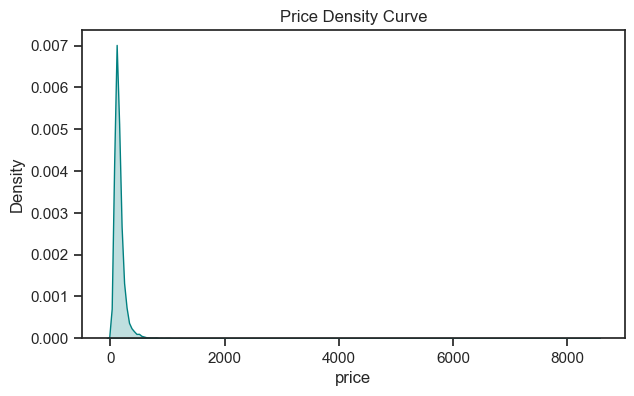

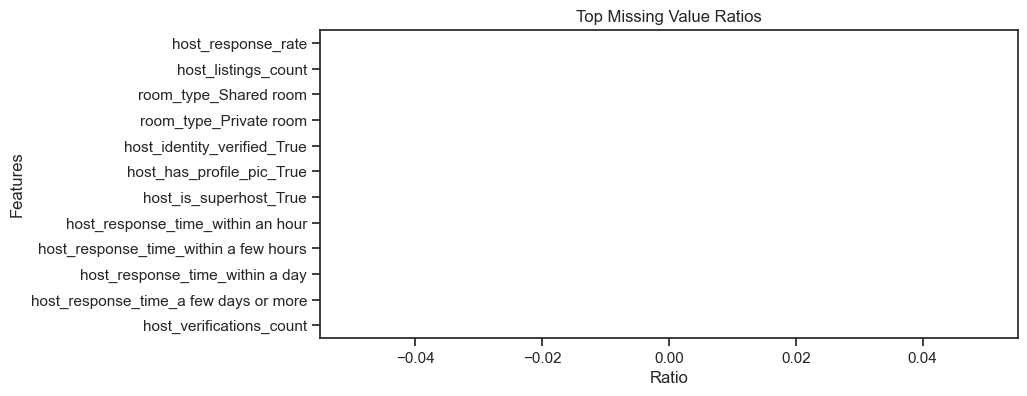

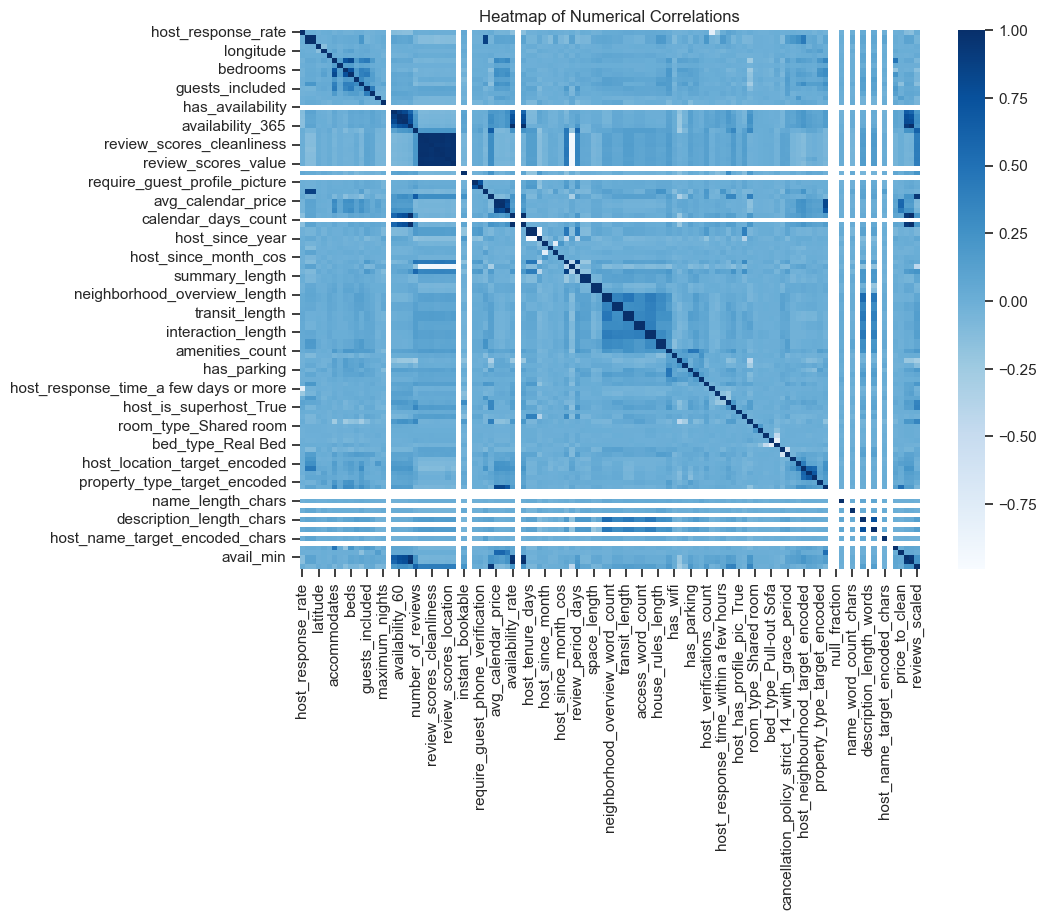

In [11]:
plt.figure(figsize=(7,4))
sns.kdeplot(y_train, fill=True, color="teal")
plt.title("Price Density Curve")
plt.show()

missing_vals = train.isna().mean().sort_values(ascending=False)
plt.figure(figsize=(9,4))
sns.barplot(
    x=missing_vals[:12],
    y=missing_vals.index[:12],
    hue=missing_vals[:12],
    dodge=False,
    palette="viridis",
    legend=False
)
plt.title("Top Missing Value Ratios")
plt.xlabel("Ratio")
plt.ylabel("Features")
plt.show()

plt.figure(figsize=(10,7))
corr = train.select_dtypes(include=np.number).corr()
sns.heatmap(corr, cmap="Blues", annot=False)
plt.title("Heatmap of Numerical Correlations")
plt.show()

### 5. SCALING

In [8]:
scaler = StandardScaler()

Xtr_scaled = scaler.fit_transform(X_train)
Xv_scaled  = scaler.transform(X_val)
Xt_scaled  = scaler.transform(X_test)

### 6. FEATURE SELECTION

In [9]:
selector = SelectKBest(mutual_info_regression, k=50)

Xtr_fs = selector.fit_transform(Xtr_scaled, y_train)
Xv_fs  = selector.transform(Xv_scaled)
Xt_fs  = selector.transform(Xt_scaled)

print("FS shape:", Xtr_fs.shape)

FS shape: (12016, 50)


### 7. DR (PCA)

PCA comp: 31


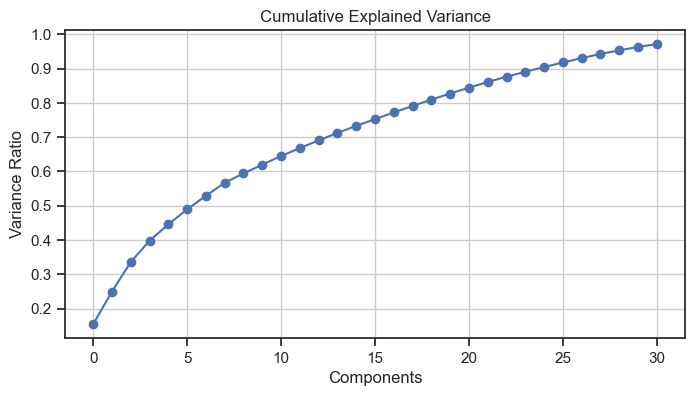

In [12]:
pca = PCA(n_components=0.97)

Xtr_pca = pca.fit_transform(Xtr_fs)
Xv_pca  = pca.transform(Xv_fs)
Xt_pca  = pca.transform(Xt_fs)

print("PCA comp:", Xtr_pca.shape[1])

# Visualization of variance
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Cumulative Explained Variance")
plt.xlabel("Components")
plt.ylabel("Variance Ratio")
plt.grid()
plt.show()

### 8. ASSESSMENT FUNCTIONS

In [13]:
def assess(model, X, y, label):
    preds = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae  = mean_absolute_error(y, preds)
    r2   = r2_score(y, preds)

    print(f"\n### {label} ###")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE : {mae:.3f}")
    print(f"R²  : {r2:.4f}")

    return rmse, mae, r2


def assess_silent(model, X, y):
    preds = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae  = mean_absolute_error(y, preds)
    r2   = r2_score(y, preds)
    return rmse, mae, r2


def assess_pair(model, Xtr, ytr, Xv, yv, label):
    print(f"\n--- {label} RESULTS ---")
    assess(model, Xtr, ytr, f"{label} TRAIN")
    assess(model, Xv,  yv,  f"{label} VAL")

### 9. MODEL 1: MLP

In [14]:
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation="tanh",
    solver="adam",
    alpha=0.001,
    learning_rate="adaptive",
    max_iter=600,
    early_stopping=True,
    random_state=12
)

mlp.fit(Xtr_pca, y_train)

assess_pair(mlp, Xtr_pca, y_train, Xv_pca, y_val, "MLP")
assess(mlp, Xt_pca, y_test, "MLP TEST")


--- MLP RESULTS ---

### MLP TRAIN ###
RMSE: 113.068
MAE : 17.917
R²  : 0.4749

### MLP VAL ###
RMSE: 130.779
MAE : 41.460
R²  : 0.2746

### MLP TEST ###
RMSE: 65.966
MAE : 40.053
R²  : 0.5514


(65.96569000785732, 40.05290036669608, 0.5514245902552919)

### 10. MODEL 2: HUBER

In [15]:
huber = HuberRegressor(
    epsilon=1.2,
    alpha=0.0005,
    max_iter=250
)

huber.fit(Xtr_pca, y_train)

assess_pair(huber, Xtr_pca, y_train, Xv_pca, y_val, "HUBER")
assess(huber, Xt_pca, y_test, "HUBER TEST")


--- HUBER RESULTS ---

### HUBER TRAIN ###
RMSE: 78.963
MAE : 31.947
R²  : 0.7439

### HUBER VAL ###
RMSE: 77.711
MAE : 35.053
R²  : 0.7439

### HUBER TEST ###
RMSE: 58.680
MAE : 35.125
R²  : 0.6450


(58.68003879846031, 35.12505303571617, 0.6450394995407858)

### 11. MODEL 3: ELASTIC NET

In [19]:
elastic = ElasticNet(
    alpha=0.001,
    l1_ratio=0.5,
    max_iter=3000,
    random_state=42
)

elastic.fit(Xtr_pca, y_train)

assess_pair(elastic, Xtr_pca, y_train, Xv_pca, y_val, "ELASTIC")
assess(elastic, Xt_pca, y_test, "ELASTIC TEST")


--- ELASTIC RESULTS ---

### ELASTIC TRAIN ###
RMSE: 73.799
MAE : 34.491
R²  : 0.7763

### ELASTIC VAL ###
RMSE: 77.114
MAE : 39.754
R²  : 0.7478

### ELASTIC TEST ###
RMSE: 65.177
MAE : 40.329
R²  : 0.5621


(65.17738164206745, 40.328586594365945, 0.562081731712144)

### 12. SUMMARY

In [20]:
summary = pd.DataFrame({
    "Model": ["MLP", "Huber", "ElasticNet"],
    "Val_R2": [
        assess_silent(mlp,   Xv_pca, y_val)[2],
        assess_silent(huber, Xv_pca, y_val)[2],
        assess_silent(elastic, Xv_pca, y_val)[2],
    ],
    "Test_R2": [
        assess_silent(mlp,   Xt_pca, y_test)[2],
        assess_silent(huber, Xt_pca, y_test)[2],
        assess_silent(elastic, Xt_pca, y_test)[2],
    ]
})

summary

,Model,Val_R2,Test_R2
0,MLP,0.274626,0.551425
1,Huber,0.743875,0.645039
2,ElasticNet,0.747797,0.562082
